# BT4222 Assignment 3
By Teo Zhi Feng (A0203989N)

# 1 Setup

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.datasets import imdb

In [ ]:
# fix random seed for reproducibility
np.random.seed(123)

#### Import IMDB Dataset

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  19.5M      0  0:00:04  0:00:04 --:--:-- 19.5M


#### Inspect folder directory

In [ ]:
!ls aclImdb
!ls aclImdb/test
!ls aclImdb/train

imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


In [ ]:
!rm -r aclImdb/train/unsup

#### Import dataset

In [ ]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 625
Number of batches in raw_val_ds: 157
Number of batches in raw_test_ds: 782


#### Inspect dataset

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'This is one of the worst movies i have seen to date, the best part was Christian J. Meoli "Leonard" attempting to act jumping up and down outside the bar, kind-of like i wanted to do on the DVD, to spare the rest of humanity the agony of watching this shitty film. It has a great cast so you keep watching waiting for it to get good, i mean with Sean Astin "Andrew" (played his part perfectly, did a great job, too bad it was in this film), Kyra Sedgwick "Bevan", Ron Livingston "Chad", Ren\xc3\xa9e Zellweger "Poet" (they put her name on the cover she has a total of 1 line and less then 4 seconds in the whole movie...<br /><br />If the cast had any dignity, they would go out and buy all the copies of this film and burn them along with Writer / Director George Hickenlooper and Writer John Enbom'
0
b"I agree that Capital City should be on DVD. I watched this show only by accident in 1994 and fell in love with Rolf Saxon as Hudson Talbot. It was nice to see Americans who work abroad in Londo

# 2 Data Pre-Processing

In [ ]:
from tensorflow.keras.layers import TextVectorization
import string
import re

#### Standardise text

In [ ]:
# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)

# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

#### Vectorise text

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 500), (None,)), types: (tf.int64, tf.int32)>

#### Inspect pre-processed dataset

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"As if there weren't enough of those floating around at the time already, we have here another lame GODFATHER clone from the director of IL CONSIGLIORI (1973) which I had watched earlier this year. The marquee-value name roped in this time is Telly Savalas who belatedly enters the proceedings and is first seen from behind, rather campily tending to his flowers and wearing a beret in the style of French painters! Apart from not looking minimally Sicilian, he sports no accent of any kind other than his familiar drawl. Antonio Sabato, then, makes for an unlikely gangster - apart from being a resistible leading man; his relationship with Savalas, which becomes paternal at the flick of an eye, is also unconvincing (especially since he subsequently becomes romantically involved with the latter's spirited teenage niece)! Besides, for a gangster flick, there's precious little action to speak of and none of it is in any way memorable (though the finale set in a clinic is well 

# 3 Convolutional Neural Network (CNN)

# 2 Data Pre-Processing

# 3 Convolutional Neural Network (CNN)

In [ ]:
epochs = 5
batch_size = 64
maxlen = 500 # max number of words in the review
max_features = 5000 # max number of words in the corpus
embedding_dims = 128   # 50 # emddeding for each word
#filters = 250
#kernel_size = 3 #size of the 1D conv. layer
hidden_dims = 250 # number of dimensions

### Build model

In [ ]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                     embedding_dims,
                     input_length=maxlen))

# Convolution layer 1
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# Max pooling
model.add(GlobalMaxPooling1D())

##### OTHER CONVOLUTION LAYERS #####

# Flatten before connecting back 
model.add(Flatten())

model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# Project onto a single unit, dense output layer and apply sigmoid activation function
# to make 0 or 1 predictions for the two classes (positive or negative).
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
# Use binary_crossentropy loss function as it is a binary classification problem 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Predict test dataset

In [ ]:
history_cnn = model.fit(x_train, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])

# history_cnn = model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_data=(x_test, y_test))

### Evaluate predictions

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 50)           250000    
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               62750     
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
activation (Activation)      (None, 250)               0

In [ ]:
accuracy_cnn = model.evaluate(x_test,y_test,verbose=0)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy_cnn[0],accuracy_cnn[1]))

Test set
  Loss: 0.516
  Accuracy: 0.891


In [ ]:
history_cnn.history

{'accuracy': [0.999822199344635, 0.9999555349349976, 1.0, 1.0],
 'loss': [0.003524243598803878,
  0.001184531836770475,
  0.00044091217569075525,
  0.00026874570176005363],
 'val_accuracy': [0.8980000019073486,
  0.8980000019073486,
  0.8971999883651733,
  0.897599995136261],
 'val_loss': [0.443440318107605,
  0.4756409525871277,
  0.49980345368385315,
  0.5171829462051392]}

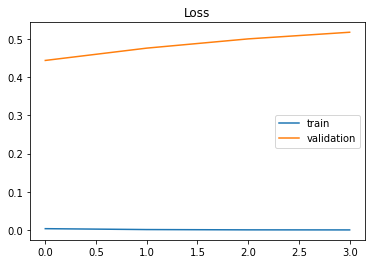

In [ ]:
plt.title('Loss')
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='validation')
plt.legend()
plt.show()

# 4 Long Short-Term Memory (LSTM) 

In [ ]:
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# 5 Model Comparison